In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile as tiff 
import cv2
from skimage.transform import resize
import seaborn as sns
from skimage.color import rgb2gray
import tensorflow_io as tfio
import pandas as pd; pd.options.mode.chained_assignment = None
from tensorflow.keras.applications import EfficientNetB6

from PIL import Image, ImageOps

tf.config.run_functions_eagerly(True)
sns.set_style('white')
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
BASE_PATH = "D:Dataset/dataset/hubmap-organ-segmentation/"

In [3]:
train = pd.read_csv(BASE_PATH+'train.csv')
test = pd.read_csv(BASE_PATH+'test.csv')

In [4]:
def rle2mask(rle, width, target_size=None):
    if target_size == None:
        target_size = width

    rle = np.array(list(map(int, rle.split())))
    label = np.zeros((width*width))
    
    for start, end in zip(rle[::2], rle[1::2]):
        label[start:start+end] = 1
        
    #Convert label to image
    label = Image.fromarray(label.reshape(width, width))
    #Resize label
    label = label.resize((target_size, target_size))
    label = np.array(label).astype(float)
    #rescale label
    label = np.round((label - label.min())/(label.max() - label.min()))
    
    return label.T

def mask2rle(mask, orig_dim=160):
    #Rescale image to original size
    size = int(len(mask.flatten())**.5)
    n = Image.fromarray(mask.reshape((size, size))*255.0)
    n = n.resize((orig_dim, orig_dim))
    n = np.array(n).astype(np.float32)
    #Get pixels to flatten
    pixels = n.T.flatten()
    #Round the pixels using the half of the range of pixel value
    pixels = (pixels-min(pixels) > ((max(pixels)-min(pixels))/2)).astype(int)
    pixels = np.nan_to_num(pixels) #incase of zero-div-error
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [5]:
class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, train=False, size=256):
        self.df = df.reset_index(drop=True)
        self.dim = size
        self.train = train
        if self.train: self.batch_size = batch_size // 4
        else: self.batch_size = batch_size
        self.pref = 'train' if train else 'test'
    
    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)
    
    def on_epoch_end(self):
        if self.train: #Reshuffle train on end of epoch
            self.df = self.df.sample(frac=1.0).reset_index(drop=True)
            
    def __getitem__(self, idx):
        batch_x = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size].id.values
        
        if not self.train:
            X = np.zeros((batch_x.shape[0], self.dim, self.dim, 3))
            
            for i in range(batch_x.shape[0]):
                image = Image.open(BASE_PATH+f"{self.pref}_images/{batch_x[i]}.tiff")
                image = image.resize((self.dim, self.dim))
                image = np.array(image) / 255.
                X[i,] = image
                
            return X
                
        else:
            batch_y = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size].rle.values
            batch_w = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size].img_width.values
            #print(batch_y, batch_w)
            X = np.zeros((batch_x.shape[0]*4, self.dim, self.dim, 3))
            Y = np.zeros((batch_x.shape[0]*4, self.dim, self.dim, 1))
            
            for i in range(batch_x.shape[0]):
                image = Image.open(BASE_PATH+f"{self.pref}_images/{batch_x[i]}.tiff")
                image = image.resize((self.dim, self.dim))
                image = np.array(image) / 255.
                rle = rle2mask(batch_y[i], batch_w[i], self.dim)
                rle = rle.reshape((self.dim, self.dim, 1))

                for n, (h, v) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
                    X[i*4 + n, :, :, :] = self.flip_image(image, h, v)[:, :, :]
                    Y[i*4 + n, :, :, :] = self.flip_image(rle, h, v)[:, :, :]
                    
            return X, Y#.reshape(Y.shape[:-1])
                
    
    def flip_image(self, image, horizontal=True, vertical=True):
        n_image = image.copy()
        
        if horizontal:
            n_image = n_image[:, ::-1, :]
        if vertical:
            n_image = n_image[::-1, :, :]
        return n_image

In [6]:
# pip install segmentation-models

In [7]:
# pip install git+https://github.com/qubvel/segmentation_models

In [6]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
from segmentation_models import Unet, FPN
from segmentation_models.utils import set_trainable

Segmentation Models: using `keras` framework.


In [7]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return weighted_loss(y_true, y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

def weighted_loss(y_true, y_pred):
    # Calculate the base loss
    bc = binary_crossentropy(y_true, y_pred)
    # Apply the weights
    one_weight = 1.0
    zero_weight = 1e-2
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weight_vector = K.squeeze(weight_vector, axis=-1)
    weighted_ce = weight_vector * bc
    # Return the mean error
    return K.mean(weighted_ce)

In [8]:
from IPython.display import clear_output
from tensorflow.keras import backend as K

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
        
    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
        plt.tight_layout()
        plt.show()

In [29]:
from sklearn.model_selection import train_test_split as tts

#We will be training a model for each organ
organs = train.organ.unique()
epochs = 20
image_size = 160
batch_size = 4
print("Organs:", organs)

Organs: ['prostate' 'spleen' 'lung' 'kidney' 'largeintestine']


In [32]:
def train_organ(organ):
    print("Training for organ:", organ)

    model = Unet('efficientnetb6',input_shape=(image_size, image_size, 3), classes=1, activation='sigmoid', encoder_weights=None)
    model.compile(loss=weighted_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy', dice_coef])

    ckp = tf.keras.callbacks.ModelCheckpoint(f"model/effB6_{organ}_model.h5", monitor="val_dice_coef",verbose=True, initial_value_threshold=0.3)
    
    X = train[train.organ == organ].reset_index(drop=True)
    train_X, valid_X = tts(X, test_size=0.15, shuffle=True, random_state=2021)
    train_loader = ImageDataGenerator(train_X, batch_size, True, image_size)
    valid_loader = ImageDataGenerator(valid_X, batch_size, True, image_size)

    history = model.fit(train_loader,validation_data=valid_loader,epochs=epochs,use_multiprocessing=False,callbacks=[PlotLearning(), ckp])

    # Model Evaluation and Predidtion
    model = tf.keras.models.load_model(f"model/effB6_{organ}_model.h5", compile=False)
    tx, ty = valid_loader[0]
    pty = model.predict(tx).round()

    # Orginal Image VS Mask
    plt.figure(figsize=(20, 20))
    for i in range(4):
        plt.figure(figsize=(20, 20))
        plt.subplot(1, 2, 1)
        plt.title('Orginal')
        plt.imshow(tx[i])
        plt.imshow(ty[i], cmap='coolwarm', alpha=0.5)
        plt.subplot(1, 2, 2)
        plt.title('Predicted')
        plt.imshow(tx[i])
        plt.imshow(pty[i], cmap='coolwarm', alpha=0.5)

* prostate

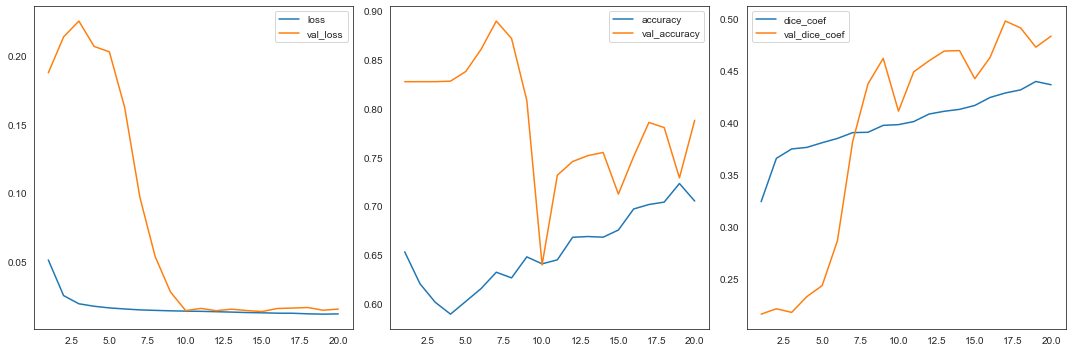


Epoch 20: saving model to model\effB6_prostate_model.h5
1/1 [==============================] - 0s 172ms/step
Training Complected for Prostate


<Figure size 1440x1440 with 0 Axes>

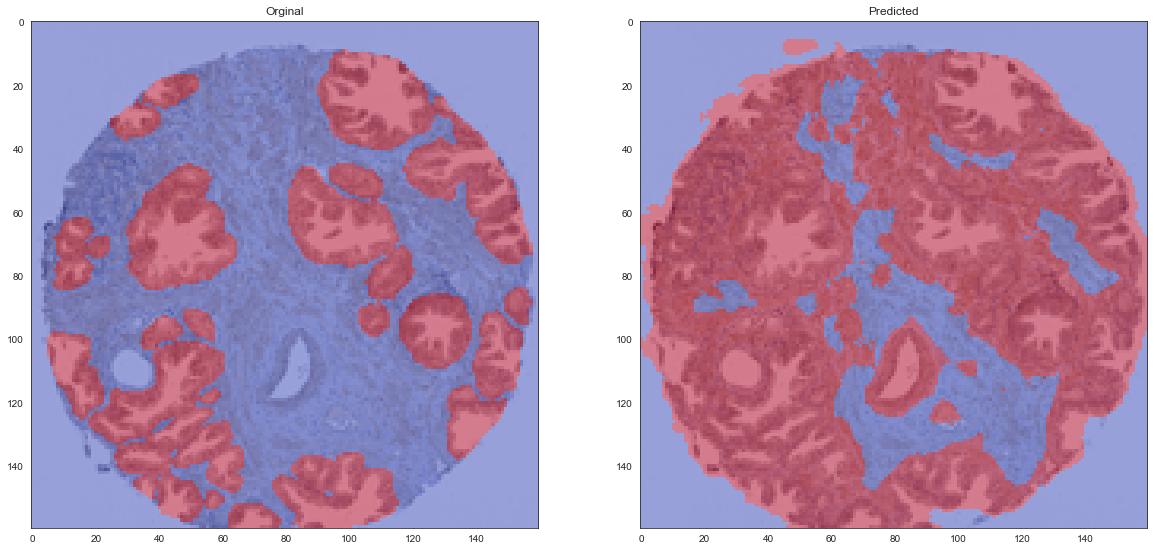

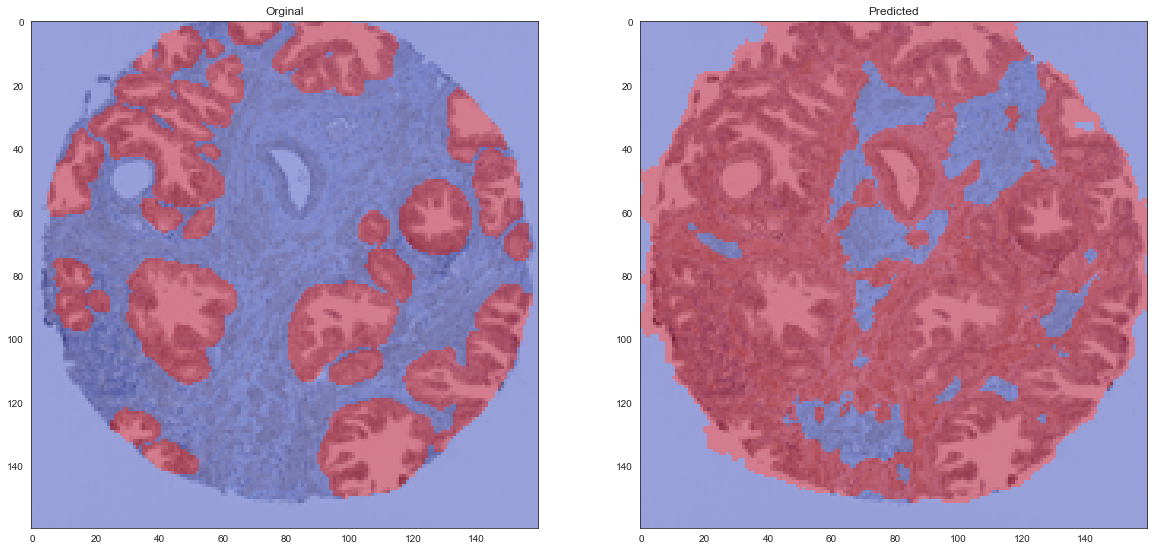

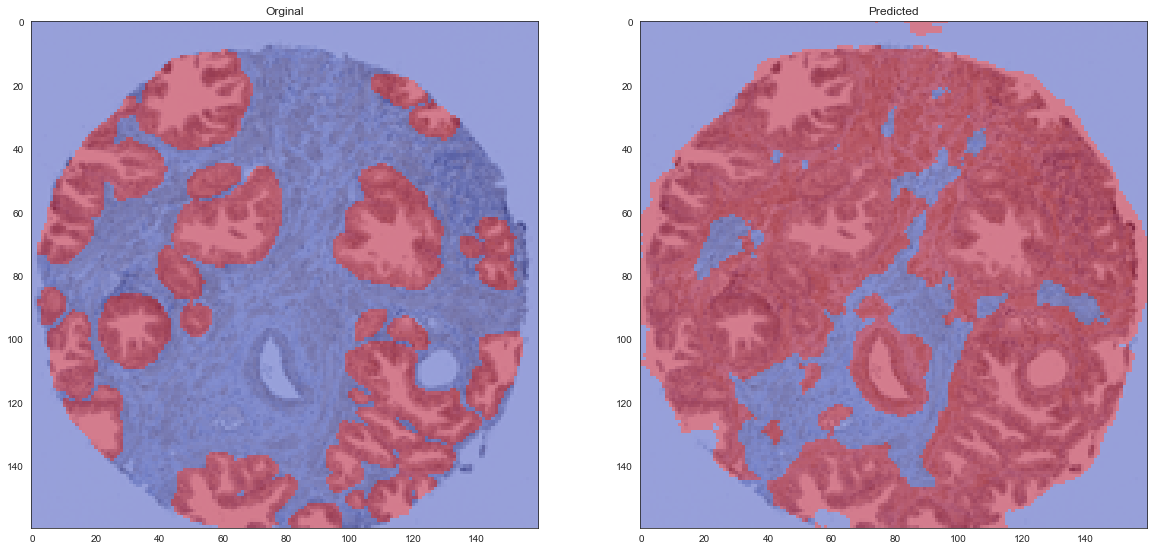

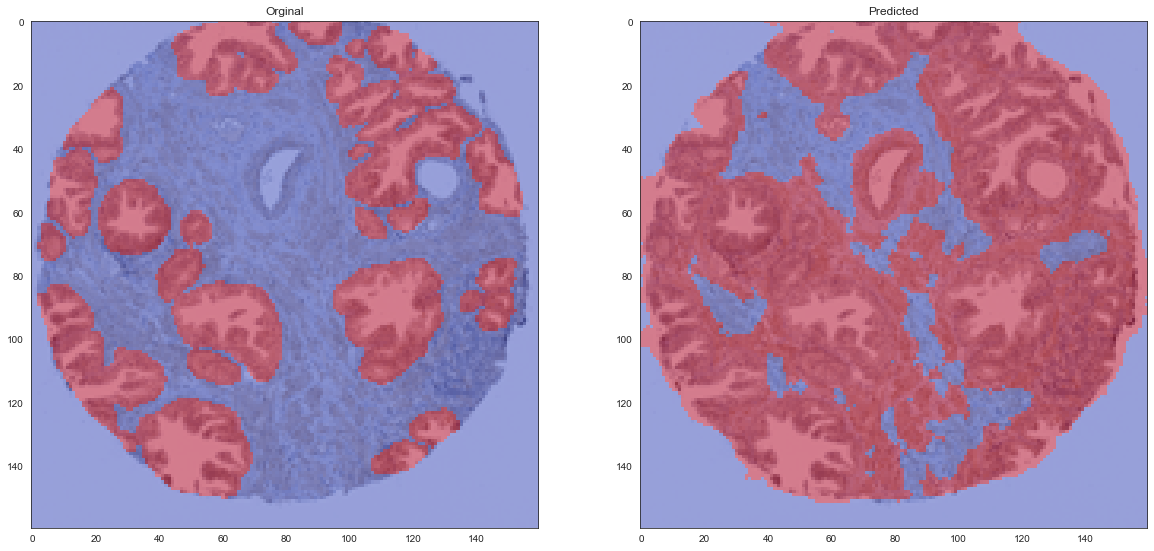

In [33]:
import gc
gc.enable()
train_organ("prostate")
print("Training Complected for Prostate")

* spleen

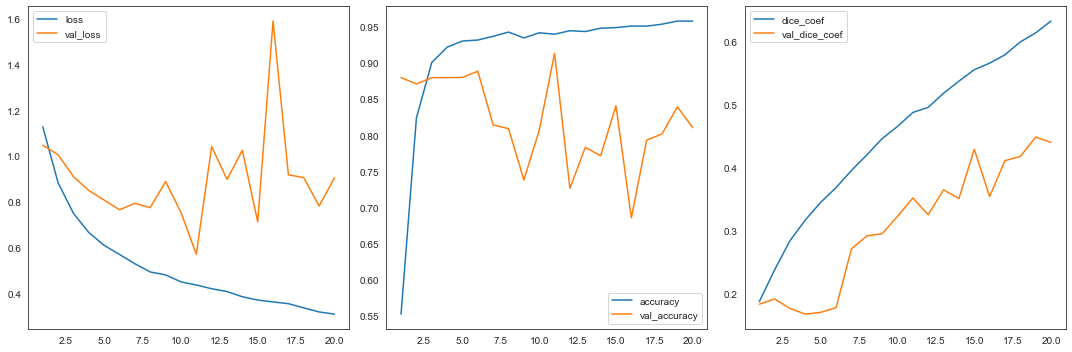


Epoch 20: val_dice_coef did not improve from 0.44930
1/1 [==============================] - 0s 184ms/step
Training Complected for Spleen


<Figure size 1440x1440 with 0 Axes>

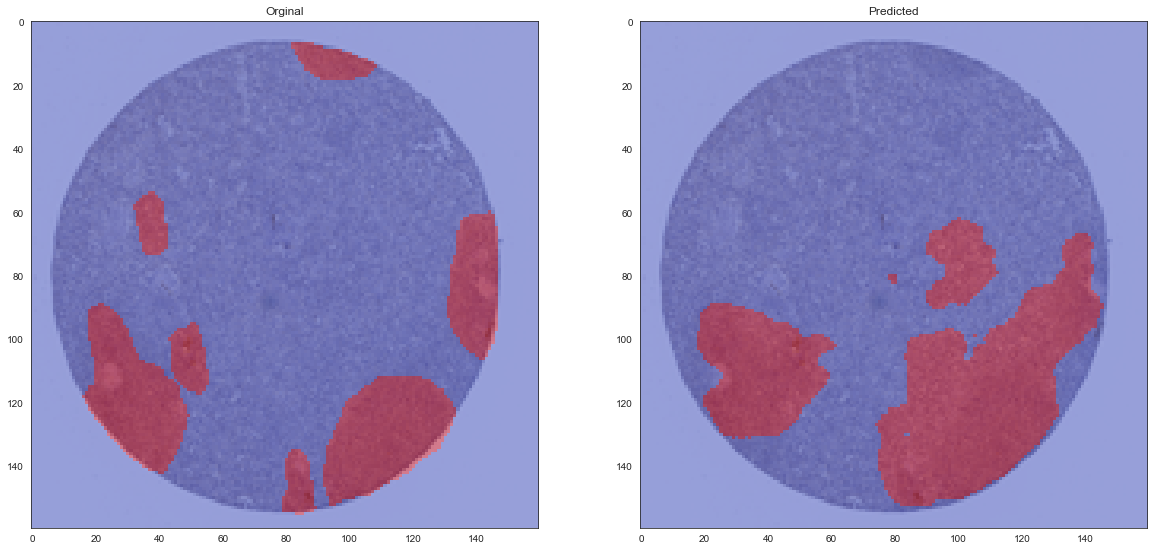

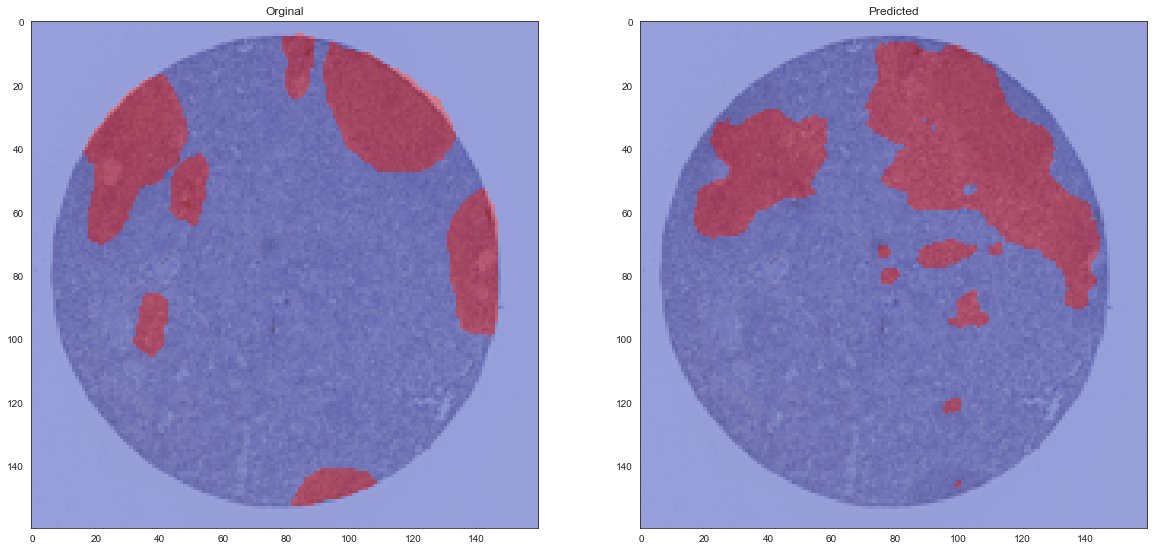

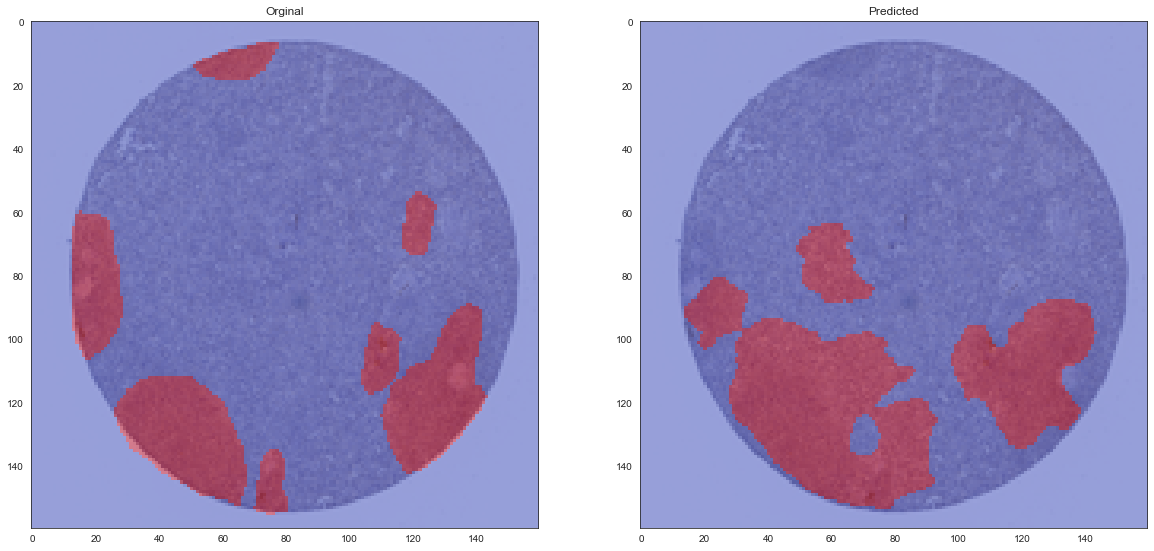

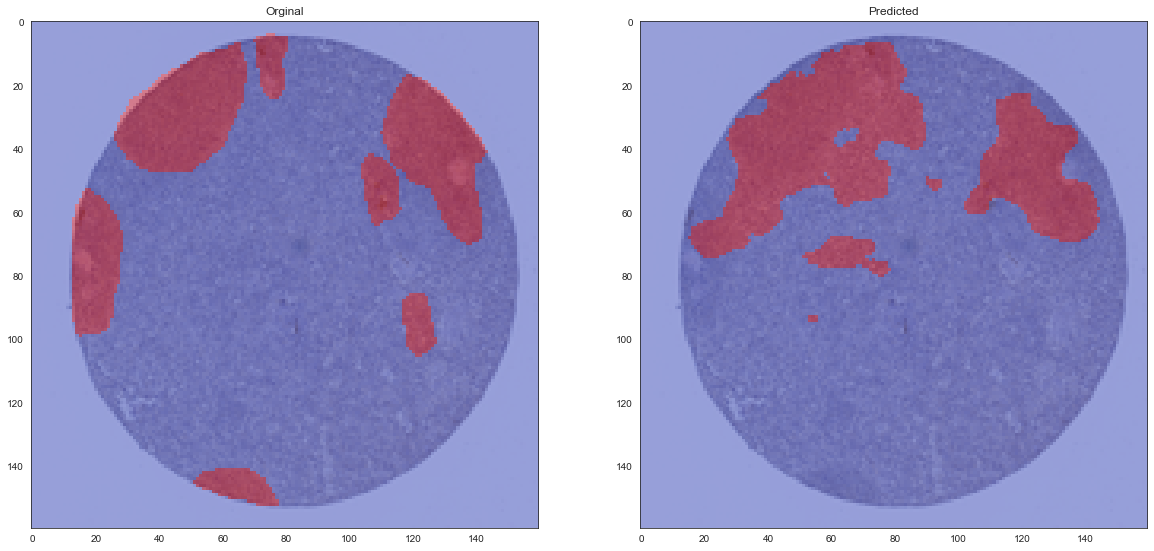

In [17]:
import gc
gc.enable()
train_organ("spleen")
print("Training Complected for Spleen")

* lung

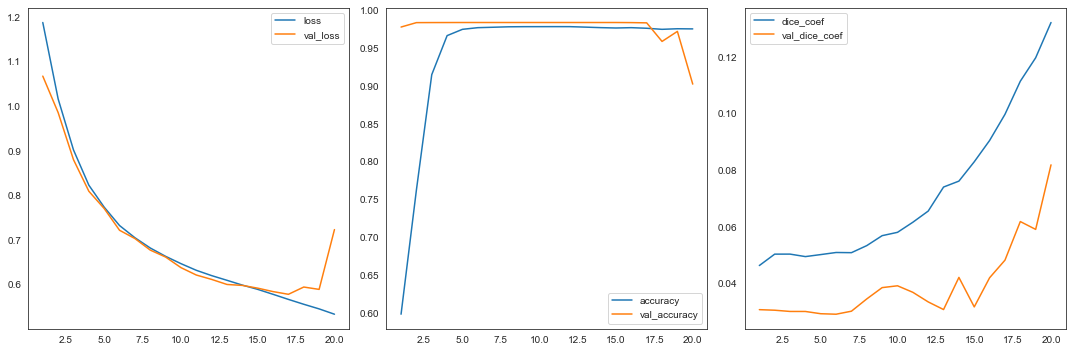


Epoch 20: val_dice_coef improved from 0.06186 to 0.08187, saving model to lung_model.h5
1/1 [==============================] - 0s 183ms/step
Training Complected for Lung


<Figure size 1440x1440 with 0 Axes>

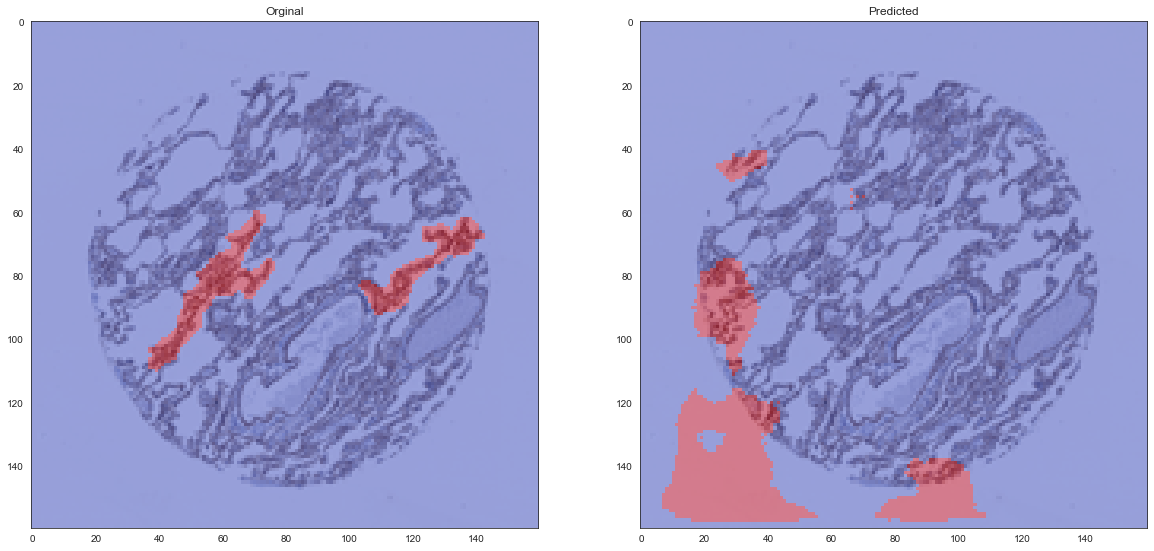

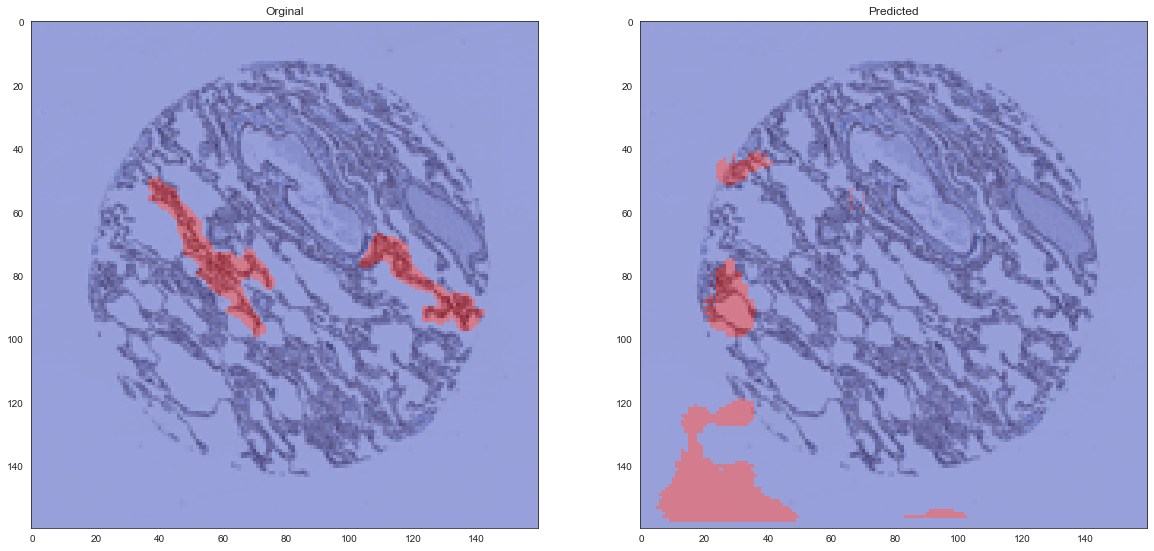

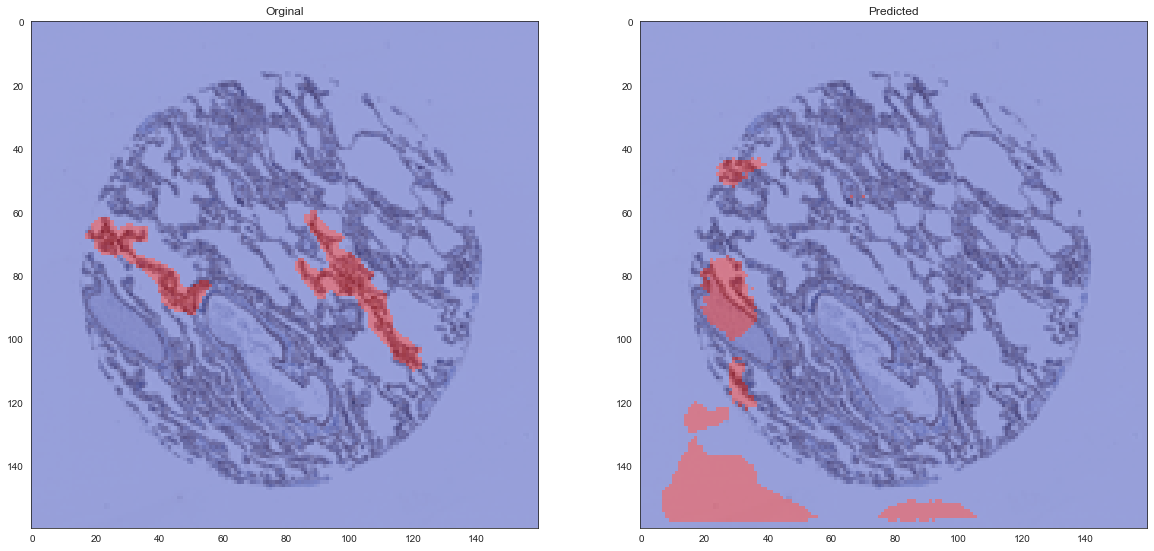

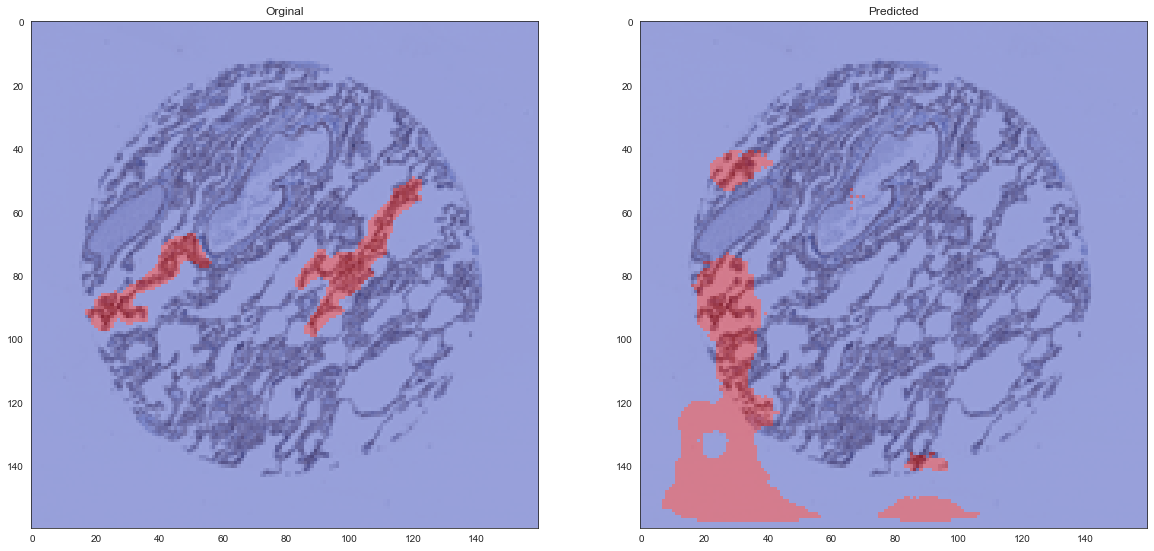

In [18]:
train_organ("lung")
print("Training Complected for Lung")

* kidney

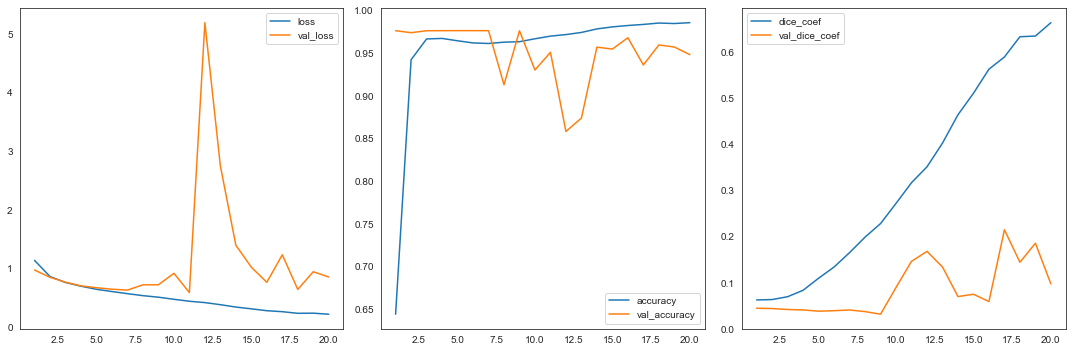


Epoch 20: val_dice_coef did not improve from 0.21437
1/1 [==============================] - 0s 177ms/step
Training Complected for Kidney


<Figure size 1440x1440 with 0 Axes>

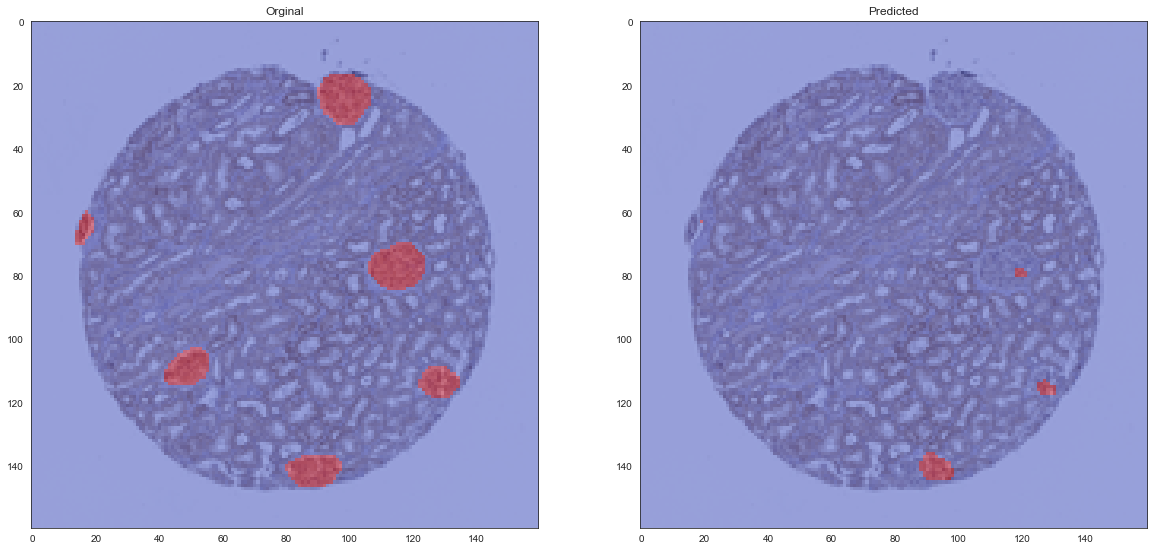

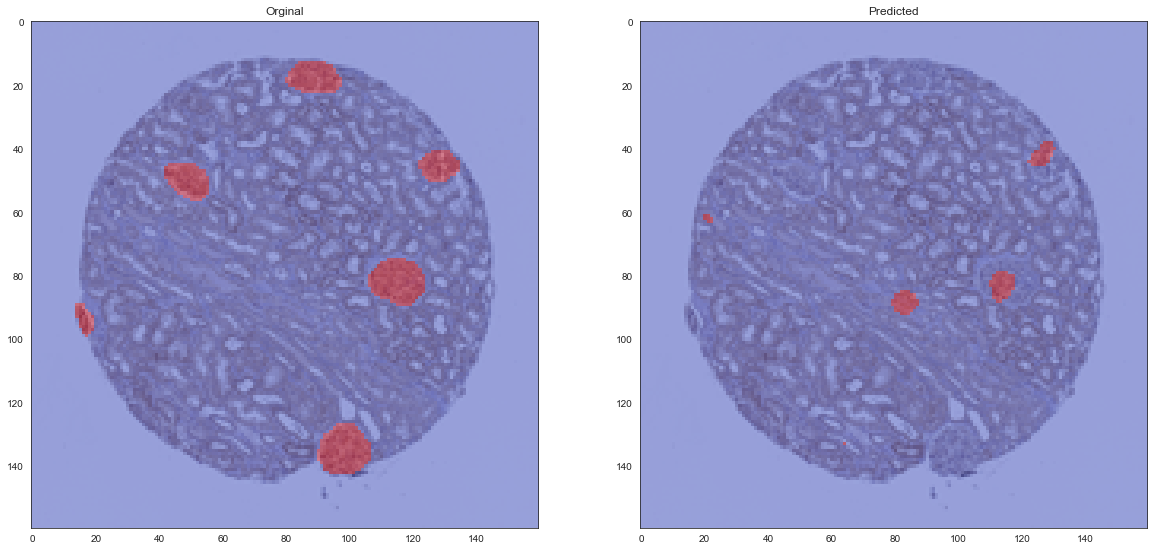

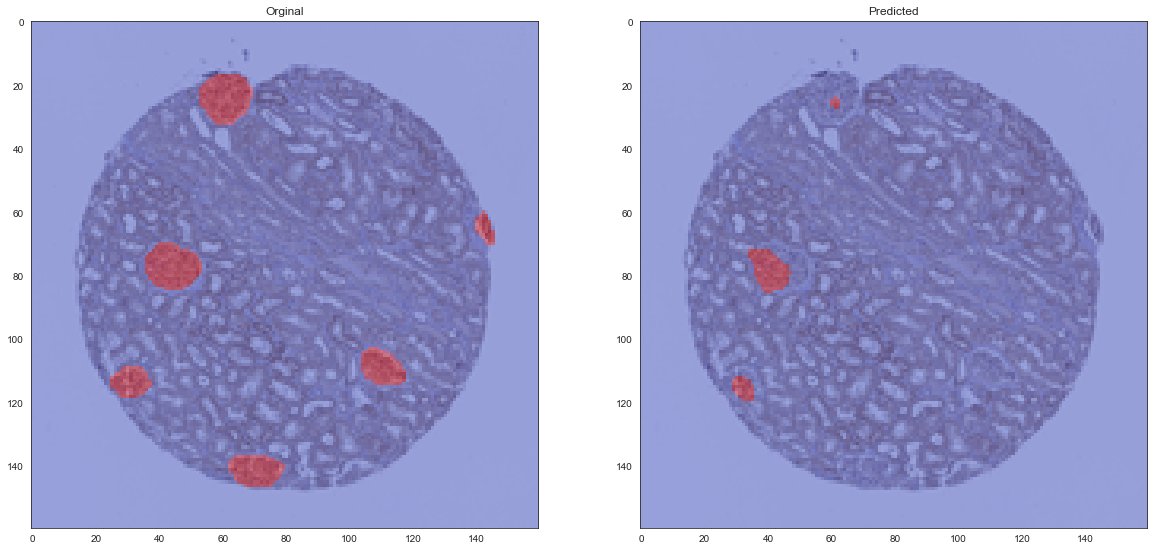

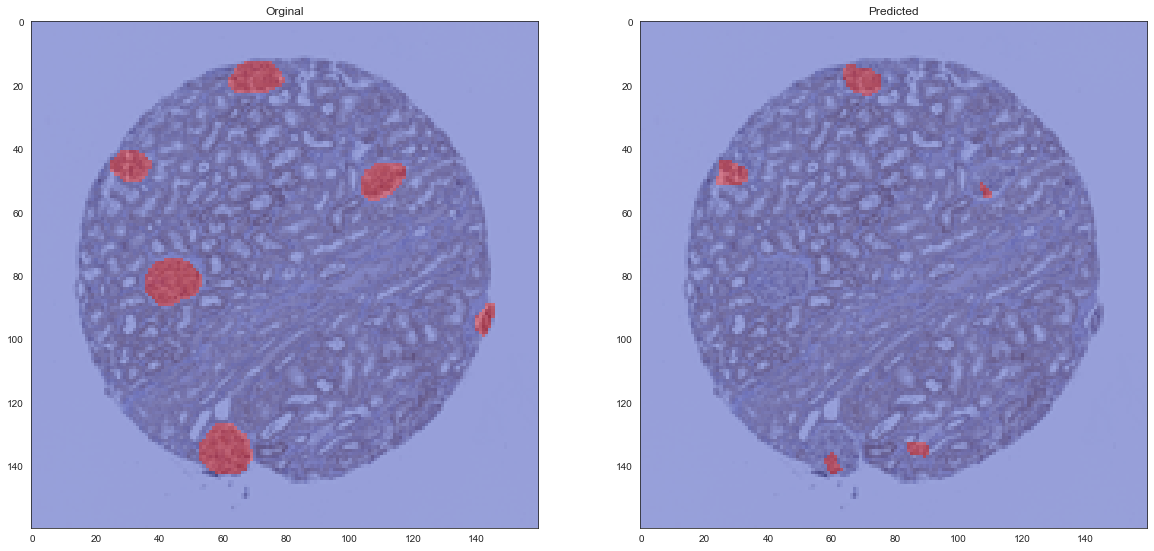

In [19]:
train_organ("kidney")
print("Training Complected for Kidney")

* largeintestine

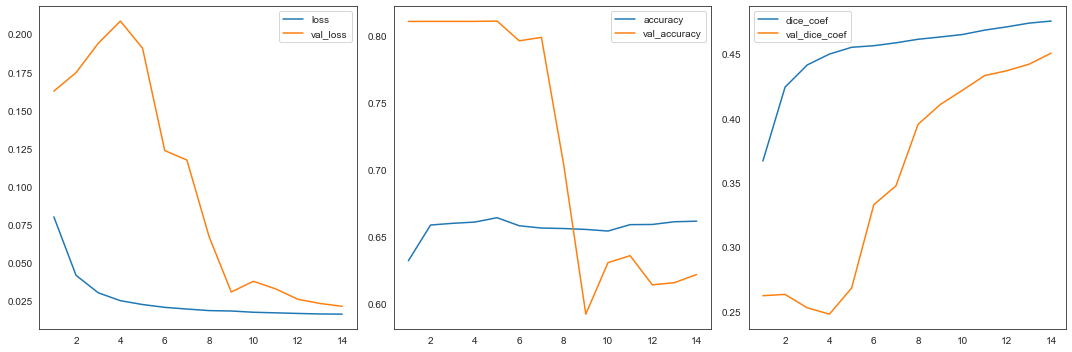

49/49 [==============================] - 29s 587ms/step - loss: 0.0164 - accuracy: 0.6615 - dice_coef: 0.4755 - val_loss: 0.0216 - val_accuracy: 0.6218 - val_dice_coef: 0.4506
Epoch 15/20
41/49 [========================>.....] - ETA: 4s - loss: 0.0163 - accuracy: 0.6652 - dice_coef: 0.4834


KeyboardInterrupt



In [13]:
train_organ("largeintestine")
print("Training Complected for Largeintestine")